In [1]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /home/schlotty/Documents/mn/metodos-num/tp3/tp3/bin/python (found version "3.6.9") 
-- Found PythonLibs: /usr/lib/x86_64-linux-gnu/libpython3.6m.so
-- pybind11 v2.2.4
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/schlotty/Documents/mn/metodos-num/tp3
-- Co

In [63]:
import pandas as pd
import seaborn as sns
import numpy as np
from numpy.linalg import solve
import matplotlib.pyplot as plt
import ipyleaflet
from ipyleaflet import Map
from scipy import stats
from sklearn.metrics import mean_squared_log_error, mean_squared_error, accuracy_score, recall_score, f1_score, cohen_kappa_score, precision_score
from sklearn.model_selection import KFold
import math
import warnings
import metnum
warnings.filterwarnings('ignore')

In [64]:
df = pd.read_csv('../data/train.csv')

## Feature engineering (básico)

Varias columnas que podrían ser interesantes como features cuentan con null values.

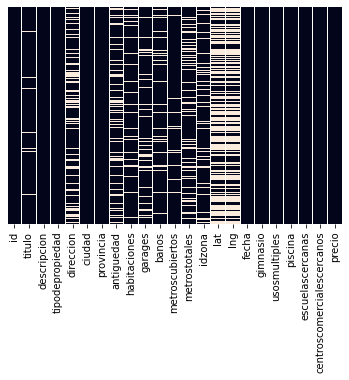

In [65]:
sns.heatmap(df.isna(), yticklabels=False, cbar=False)

In [66]:
pd.DataFrame(df.isna().sum()).sort_values(by=0)

,0
id,0
escuelascercanas,0
piscina,0
usosmultiples,0
gimnasio,0
fecha,0
centroscomercialescercanos,0
precio,0
tipodepropiedad,46
provincia,155


Inferimos la información faltante tomando la media de los valores que si están presentes en cada columna.

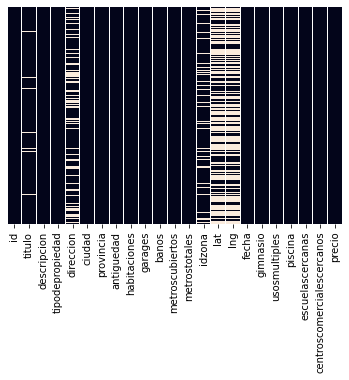

In [67]:
quantity_columns = ['antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos', 'metrostotales']

for col in quantity_columns:
    df[col] = df[col].fillna(df[col].mean())

sns.heatmap(df.isna(), yticklabels=False, cbar=False)

## Prueba

El objetivo es, en base a un segmento del dataset determinado:

* determinar features que nos permitan predecir el precio de la propiedad
* desarrollar de forma básica la elaboración de un modelo que permita hacerlo
* probar el/los modelos encontrados contra otro segmento

### Función auxiliar

In [68]:
def plot(pos, x, y, y_pred, eps, title, style='r'):
    ax1 = plt.subplot(pos)
    ax1.plot(x, y, '.')
    ax1.plot(x, y_pred, style)
    ax1.set_title(f'fit {title}')
    ax1.set_xlabel("metroscubiertos")
    ax1.set_ylabel("precio")
    ax1.grid(True)

    ax2 = plt.subplot(pos+1)
    ax2.plot(x, eps, '.')
    ax2.set_title(f'residuals {title}')
    ax2.set_xlabel("metroscubiertos")
    ax2.set_ylabel("diferencia")
    ax2.grid(True)

def train_and_predict(train_df, test_df, apply_x, apply_y, f, plot_train, plot_fit, verbose):

    regressor = metnum.LinearRegression()
    x = train_df['metroscubiertos']
    y = train_df['precio']
    x_test = test_df['metroscubiertos']
    y_test = test_df['precio']
    
    A = apply_x(x)
    b = apply_y(y)

    regressor.fit(A, b)
    
    coefs = regressor.coef()

    if plot_train or plot_fit:
        plt.figure(figsize=(12, 12))
    
    if plot_train:
        y_pred = f(x, coefs)
        plot(221, x, y, y_pred, y - y_pred, 'train', '.')
    
    y_pred = f(x_test, coefs)
    if plot_fit:
        plot(223, x_test, y_test, y_pred, y_test - y_pred, 'test', '.')
        
    error = np.sqrt(mean_squared_log_error(y_test, y_pred))
    
    if verbose:
        print(f"ERROR: {error}")
        print(f"COEFS: {coefs}\n")

    if plot_train or plot_fit:
        plt.show()

    return error, coefs

def cross(train_df, test_df, apply_x, apply_y, f, plot_train=False, k=5):
    errors = []

    kf = KFold(n_splits=k, shuffle=True, random_state=17)

    # prueba cross validation
    for train_index, test_index in kf.split(train_df):
        
        train_set = train_df.iloc[train_index]
        train_set = train_set.groupby('metroscubiertos').mean().reset_index()
        
        test_set = train_df.iloc[test_index]
        
        error, _ = train_and_predict(
            train_set,
            test_set,
            apply_x,
            apply_y,
            f,
            plot_train,
            False,
            False
        )

        errors.append(error)

    mean = np.mean(np.array(errors))
    var = np.var(np.array(errors))
    print(f"MEAN ERRORS: {mean}")
    print(f"VAR ERRORS: {var}\n")

    coefs = []
    return coefs, mean, var

### Segmentación básica

In [69]:
selection_df = df[
    (df['ciudad'] == 'Querétaro') &
    (df['tipodepropiedad'] == 'Casa')
].dropna()

## Feature selection

En esta sección probamos dos técnicas para elegir los features con los que vamos a armar el modelo para predecir los precios.

* Por correlation matrix selection
* <s>Por forward selection</s>

### Correlation matrix feature selection

Se observa una correlación (positiva y negativa) entre:

* metrostotales
* banos
* metroscubiertos
* precio

Lo que nos dice en primera instancia que el precio podría ser explicado por los otros tres features en principio.

In [70]:
cor = abs(selection_df.corr()['precio'])
cor_target = cor[cor > 0.5]
cor_target.sort_values()

metrostotales      0.560572
banos              0.566573
metroscubiertos    0.790526
precio             1.000000
Name: precio, dtype: float64

No obstante, cuando revisamos los features restantes dos a dos, obtenemos que la correlación entre ellos podría considerarse también alta, con lo que sólo una de ellas sería necesaria para explicar el precio. En este primer caso, tomamos `metroscubiertos` ya que tiene mayor correlación con `precio`.

In [71]:
print(selection_df[['metroscubiertos', 'banos']].corr())

                 metroscubiertos     banos
metroscubiertos         1.000000  0.635072
banos                   0.635072  1.000000


En este segundo caso, como se mencionó antes, la correlación también es alta, por lo que se optó por mantener `metroscubiertos` por la razón comentada previamente.

In [72]:
print(selection_df[['metroscubiertos', 'metrostotales']].corr())

                 metroscubiertos  metrostotales
metroscubiertos         1.000000       0.576427
metrostotales           0.576427       1.000000


In [73]:
print(selection_df[['banos', 'metrostotales']].corr())

                 banos  metrostotales
banos          1.00000        0.46903
metrostotales  0.46903        1.00000


En conclusión, `metroscubiertos` explicaría bien el precio para la segmentación que estamos probando.

#### Comportamiento del feature respecto del target

El objetivo es inferir la relación entre, en este caso `precio` en función de `metroscubiertos`. Grafiquemos para tener una primera intuición:

train_df (2379, 2)
test_df (0, 0)


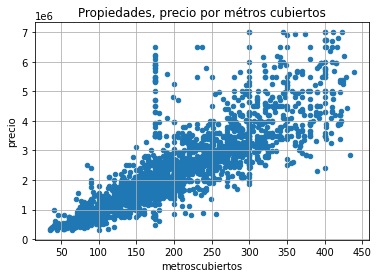

In [74]:
#limit = math.floor(selection_df.shape[0] * .9)

#train_df = selection_df[:limit][['metroscubiertos', 'precio']]
#test_df = selection_df[limit:][['metroscubiertos', 'precio']]

train_df = selection_df[['metroscubiertos', 'precio']]
test_df = pd.DataFrame()

print(f"train_df {train_df.shape}")
print(f"test_df {test_df.shape}")

# removemos outliers de train set
train_df = train_df[(np.abs(stats.zscore(train_df)) < 3).all(axis=1)]

# graficamos para hacernos una idea de la linealidad entre las dos variables
train_df.plot.scatter(y='precio', x='metroscubiertos')
plt.title("Propiedades, precio por métros cubiertos")
plt.grid(True)
plt.show()

Observemos lo siguiente:

* Hay mucha información presente como para inferir un patrón que nos permita deducir una función de comportamiento.
* Para valores específicos de `metroscubiertos` hay diferentes precios disponibles en un amplio rango de valores, por lo que fitear eso añade complejidad al problema cuando un valor más adecuado para aproximar a estos casos es a la media de los valores de las propiedades.

Para ambos problemas, se propone lo siguiente:

* segmentar más
* agrupar por `metroscubiertos` y obtener la media de los precios

Optamos por la segunda alternativa, y trataremos de predecir los precios reales de las propiedades mediante de la elaboración de un modelo a partir de esta propuesta.

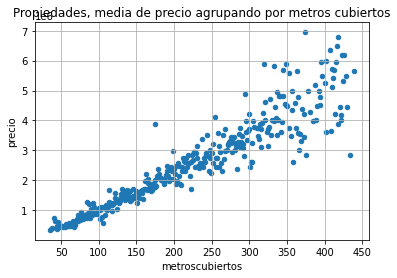

In [75]:
_train_df = train_df.groupby('metroscubiertos').mean().reset_index()

# graficamos para hacernos una idea de la linealidad entre las dos variables
_train_df.plot.scatter(y='precio', x='metroscubiertos')
plt.title("Propiedades, media de precio agrupando por metros cubiertos")
plt.grid(True)
plt.show()

Se puede ver como la varianza va incrementando poco a poco a medida que la cantidad de `metroscubiertos` aumenta. Esto podria traernos luego complicaciones para fitear esos datos ya que puede ser más dificil encontrar una función que los represente. Aplicar una transformación a los datos nos ayudaría a reducir un poco esa varianza y a hacer más certera nuestra aproximación. Aplicando $log$ sobre los dos features:

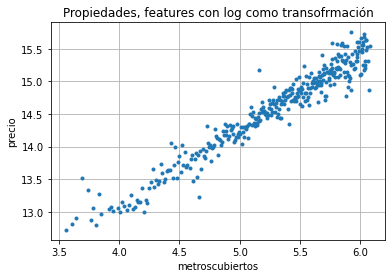

In [76]:
plt.plot(np.log(_train_df['metroscubiertos']), np.log(_train_df['precio']), '.')
plt.title("Propiedades, features con log como transofrmación")
plt.xlabel("metroscubiertos")
plt.ylabel("precio")
plt.grid(True)
plt.show()

Lo que ahora nos facilita plantear la siguiente regresión:

$$log(y) = \alpha_1 + \alpha_2 * log(x)$$

Observemos que en base a la misma

$$y = e^{\alpha_1 + \alpha_2 * log(x)}$$

In [77]:
def apply_x(x):
    return np.stack(evaluate(x)).T

def apply_y(y): return np.log(y)

def f(x,coef):
    result = sum([c * v for c, v in zip(coef, evaluate(x))])
    return np.e**result

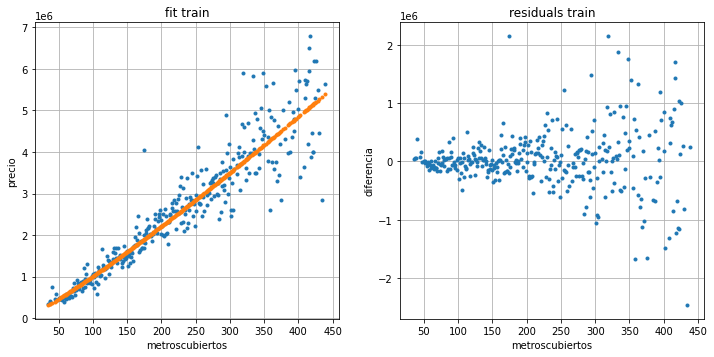

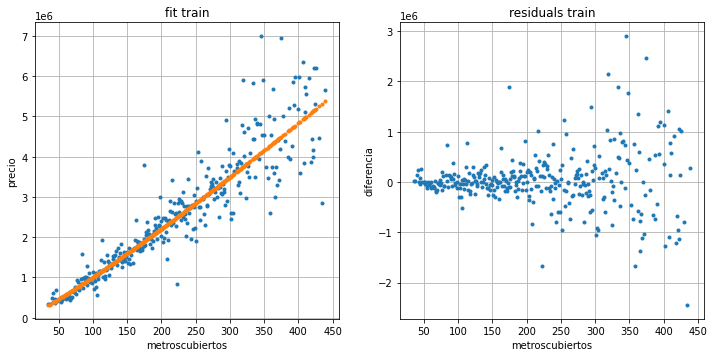

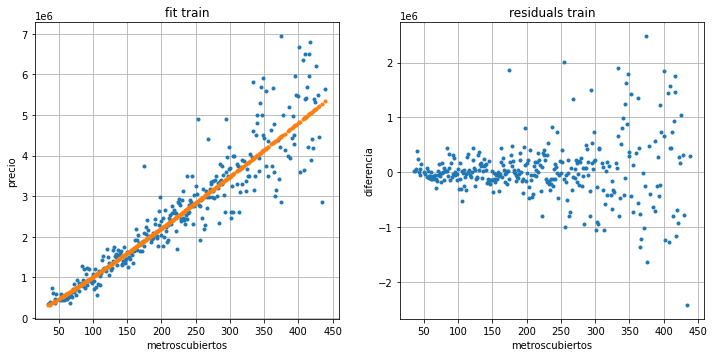

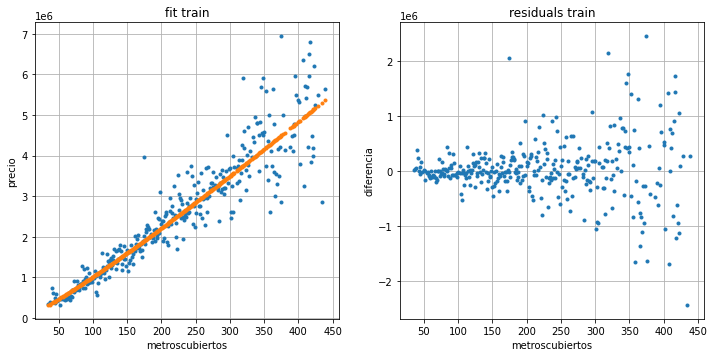

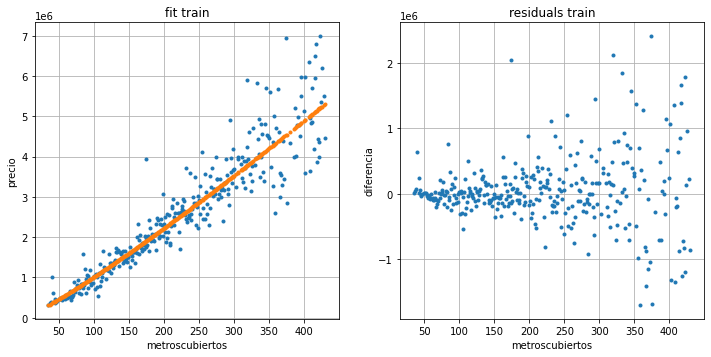

MEAN ERRORS: 0.2826833109737838
VAR ERRORS: 0.0002106545272126025



In [93]:
all_means = []
all_vars = []

def evaluate(x):
    ones = np.ones(x.shape)
    return [
        ones,
        np.log(x)
    ]

_, m, v = cross(train_df, test_df, apply_x, apply_y, f, True)

all_means.append(m)
all_vars.append(v)

Observemos que $y \approx x^{1.12} * e^{8.65}$ por la igualdad previa. Con lo que $y$ es parecida a una función lineal, la cual puede verse en los plots de fit.

Aunque hay una aproximación, y el ajuste en el test set no parece ser tan malo, se observa en los plots de residuals diferencias más dispersas conforme los metros cubiertos aumentan, lo que nos indica que el error, $\epsilon$ no tiene distribución $N\sim(0, \sigma^2)$ con $\sigma^2$ constante para todos los valores de $x$. Esto nos lleva a que puede ser mejorada la aproximación. Idealmente, en este plot estaríamos buscando puntos muy cercanos al cero con una varianza uniforme.

Seguidamente, podemos intentar agregando términos polinómicos, sólo para ver que tan preponderantes son al hacer las predicciones:

$$log(y) = \alpha_1 + \alpha_2 * log(x) + \alpha_3 * x $$

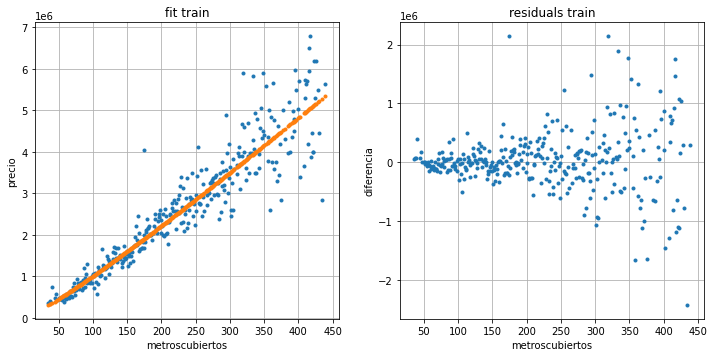

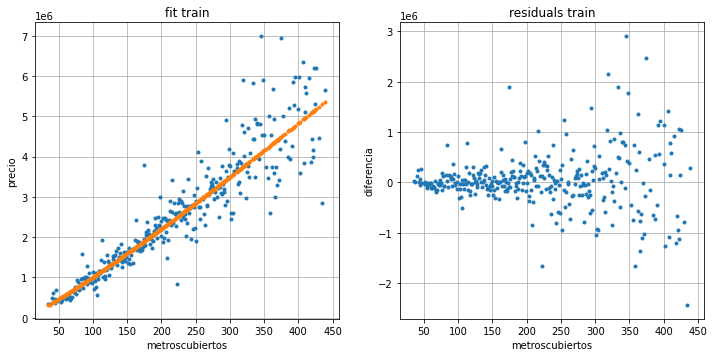

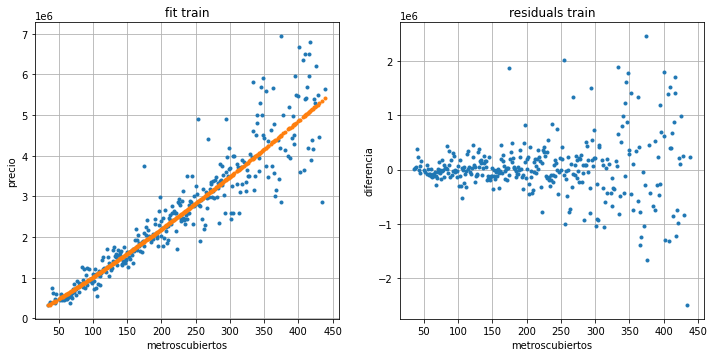

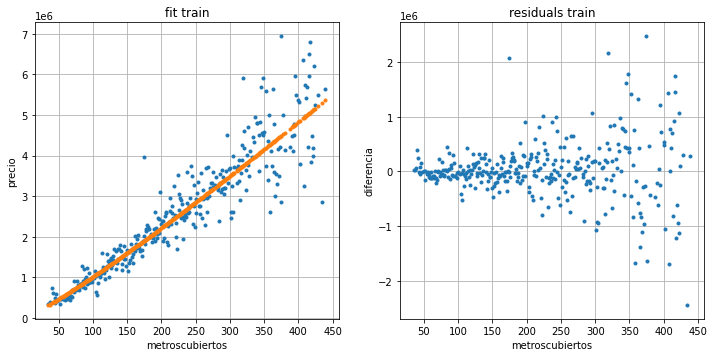

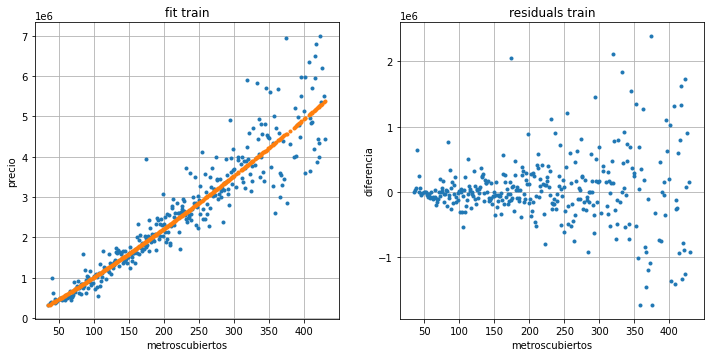

MEAN ERRORS: 0.2828156752903608
VAR ERRORS: 0.00020512510744353035



In [94]:
def evaluate(x):
    ones = np.ones(x.shape)
    return [
        ones,
        np.log(x),
        x,
    ]

_, m, v = cross(train_df, test_df, apply_x, apply_y, f, True)

all_means.append(m)
all_vars.append(v)

$$log(y) = \alpha_1 + \alpha_2 * log(x) + \alpha_3 * x^2 $$

In [95]:
def evaluate(x):
    ones = np.ones(x.shape)
    return [
        ones,
        np.log(x),
        x**2,
    ]

_, m, v = cross(train_df, test_df, apply_x, apply_y, f, False)

all_means.append(m)
all_vars.append(v)

MEAN ERRORS: 0.28268967532791633
VAR ERRORS: 0.00020757919521226828



$$log(y) = \alpha_1 + \alpha_2 * log(x) + \alpha_3 * x^3 $$

In [96]:
def evaluate(x):
    ones = np.ones(x.shape)
    return [
        ones,
        np.log(x),
        x**3,
    ]

_, m, v = cross(train_df, test_df, apply_x, apply_y, f, False)

all_means.append(m)
all_vars.append(v)

MEAN ERRORS: 0.282625630696955
VAR ERRORS: 0.00020890968237248189



$$log(y) = \alpha_1 + \alpha_2 * log(x) + \alpha_3 * x^4 $$

In [97]:
def evaluate(x):
    ones = np.ones(x.shape)
    return [
        ones,
        np.log(x),
        x**4,
    ]

_, m, v = cross(train_df, test_df, apply_x, apply_y, f, False)

all_means.append(m)
all_vars.append(v)

MEAN ERRORS: 0.2825961066262056
VAR ERRORS: 0.00020978902809982007



$$log(y) = \alpha_1 + \alpha_2 * log(x) + \alpha_3 * x + \alpha_4 * x^2 + \alpha_5 * x^3 + \alpha_6 * x^2 $$

In [98]:
def evaluate(x):
    ones = np.ones(x.shape)
    return [
        ones,
        np.log(x),
        x,
        x**2,
        x**3,
        x**4
    ]

_, m, v = cross(train_df, test_df, apply_x, apply_y, f, False)

all_means.append(m)
all_vars.append(v)

MEAN ERRORS: 0.28130698374635565
VAR ERRORS: 0.00020309244731344587



Repasemos los resultados para las diferentes combinaciones que intentamos:

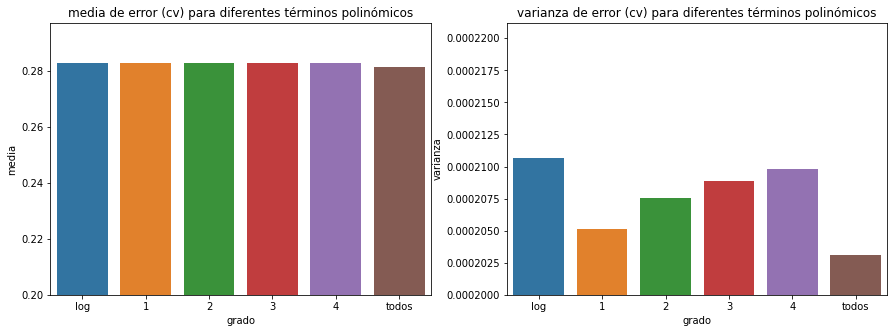

([0.2826833109737838,
  0.2828156752903608,
  0.28268967532791633,
  0.282625630696955,
  0.2825961066262056,
  0.28130698374635565],
 [0.0002106545272126025,
  0.00020512510744353035,
  0.00020757919521226828,
  0.00020890968237248189,
  0.00020978902809982007,
  0.00020309244731344587])

In [102]:
labels=["log", "1", "2", "3", "4", "todos"]

g, axes = plt.subplots(1, 2, figsize=(15, 5))

ax = sns.barplot(y=all_means, x=labels, ax=axes[0])
ax.set_title("media de error (cv) para diferentes términos polinómicos")
ax.set(xlabel="grado", ylabel="media")
ax.set_ylim(ymin=0.2)

ax = sns.barplot(y=all_vars, x=labels, ax=axes[1])
ax.set_title("varianza de error (cv) para diferentes términos polinómicos")
ax.set(xlabel="grado", ylabel="varianza")
ax.set_ylim(ymin=0.0002)

plt.show()

all_means, all_vars

Ninguno de los términos polinómicos parece mejorar mucho la media del error respecto a la propuesta inicial (log). Tampoco hay una diferencia notable respecto a la varianza del error. Siendo mayor cuando se aplican todos los términos juntos. Podríamos tomar uno de ellos y tratar de avanzar buscando un modelo por comparación con el original.

Si observamos los plots de residuals del modelo original y el correspondiente a la prueba con el término cúbico, veremos que son parecidos: $\epsilon$ sigue teniendo una media de $0$, pero la varianza aún no es uniforme.

En conclusión, aunque el término cúbico no presente una mejora, puede ser interesante observar el comportamiento de estos dos modelos con otras funciones de la familia.

Probemos el modelo original (log) contra el extendido con el polínomio de grado 3 con funciones periódicas.

$$log(y) = \alpha_1 + \alpha_2 * log(x) + \alpha_3 * \phi(x) * sin(\frac{x}{k})$$

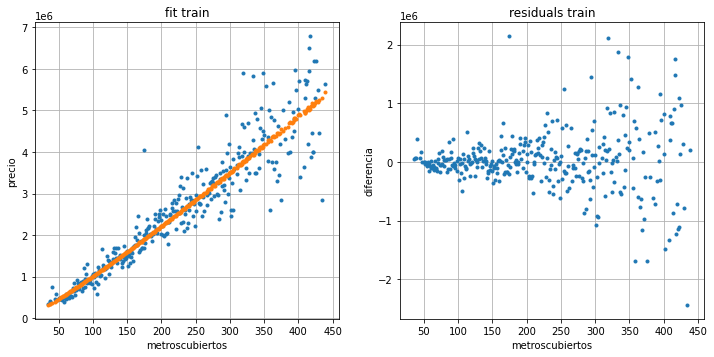

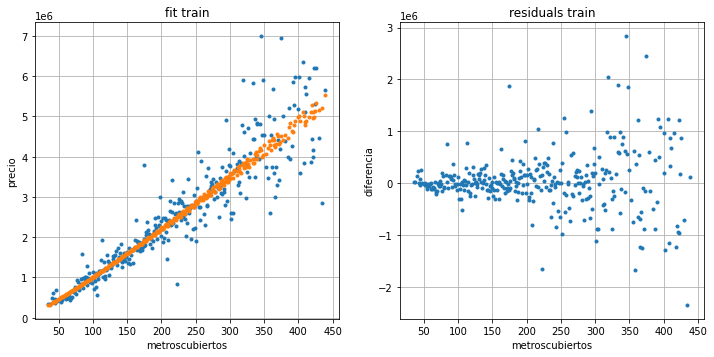

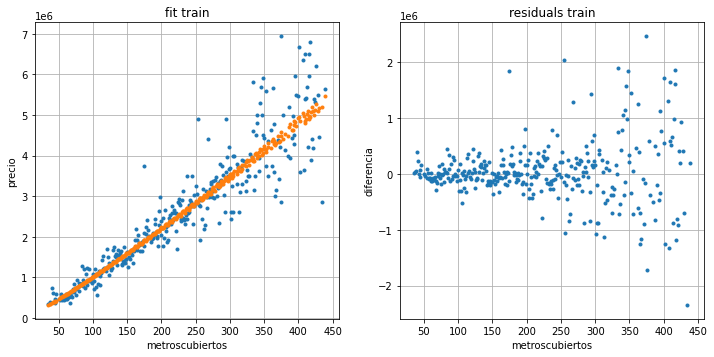

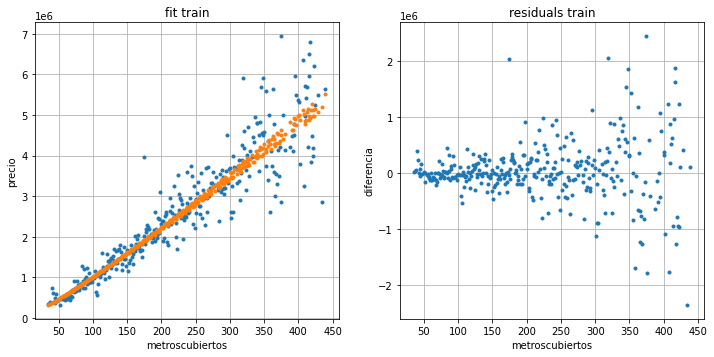

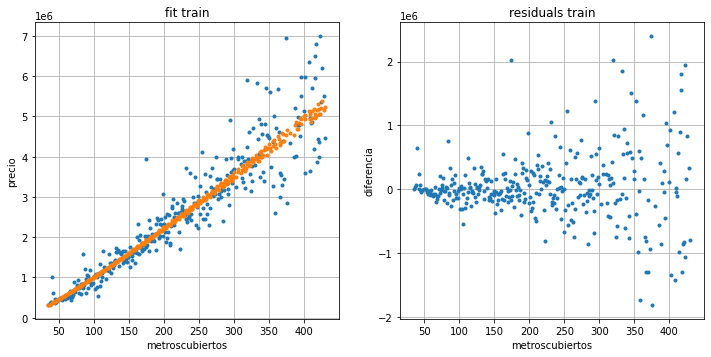

MEAN ERRORS: 0.282447622602686
VAR ERRORS: 0.00020765253598783334



In [103]:
all_means=[]
all_vars=[]

def evaluate(x):
    ones = np.ones(x.shape)
    return [
        ones,
        np.log(x),
        x * np.sin(x)
    ]

_, m, v = cross(train_df, test_df, apply_x, apply_y, f, True)

all_means.append(m)
all_vars.append(v)

$$log(y) = \alpha_1 + \alpha_2 * log(x) + \alpha_3 * x^3 + \alpha_4 * \phi(x) * sin(\frac{x}{k})$$

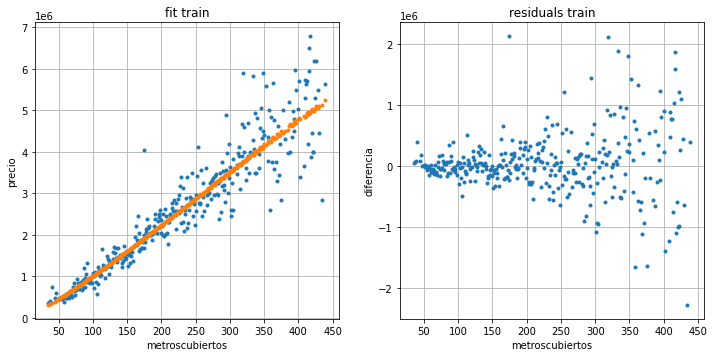

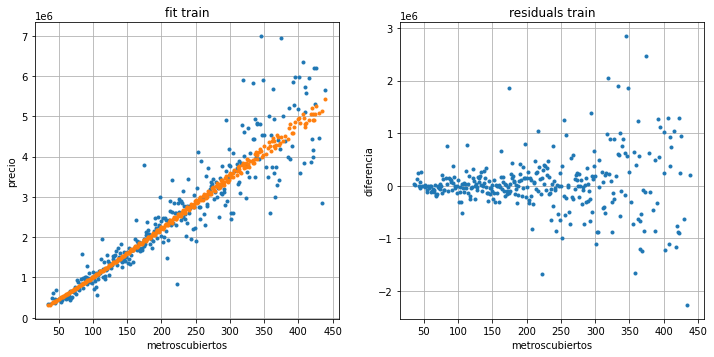

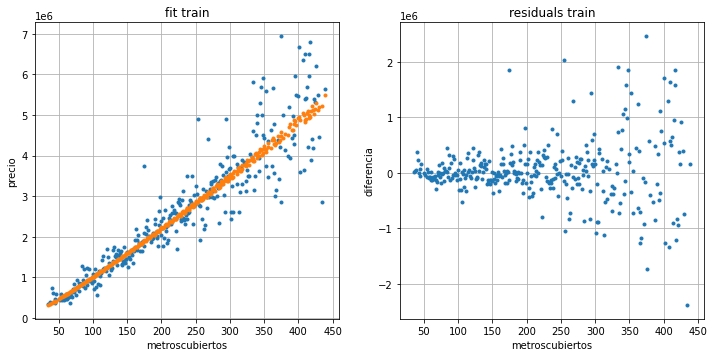

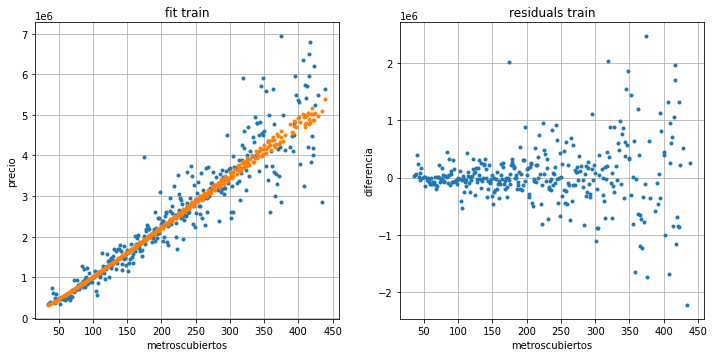

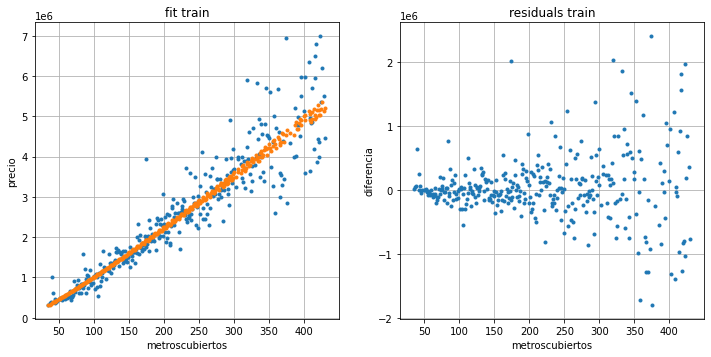

MEAN ERRORS: 0.2823956042594708
VAR ERRORS: 0.00020577697662393127



In [104]:
def evaluate(x):
    ones = np.ones(x.shape)
    return [
        ones,
        np.log(x),
        x**3,
        x * np.sin(x)
    ]

_, m, v = cross(train_df, test_df, apply_x, apply_y, f, True)

all_means.append(m)
all_vars.append(v)

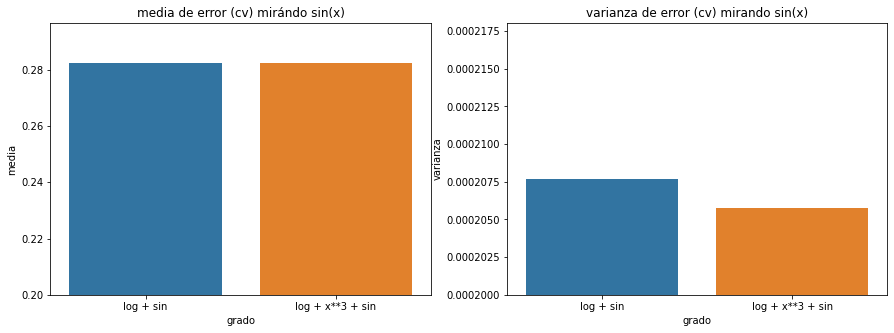

In [107]:
labels=["log + sin", "log + x**3 + sin"]

g, axes = plt.subplots(1, 2, figsize=(15, 5))

ax = sns.barplot(y=all_means, x=labels, ax=axes[0])
ax.set_title("media de error (cv) mirándo sin(x)")
ax.set(xlabel="grado", ylabel="media")
ax.set_ylim(ymin=0.2)

ax = sns.barplot(y=all_vars, x=labels, ax=axes[1])
ax.set_title("varianza de error (cv) mirando sin(x)")
ax.set(xlabel="grado", ylabel="varianza")
ax.set_ylim(ymin=0.0002)

plt.show()

Si bien en el plot de residuals seguimos notando la varianza no constante, el error de la aproximación es también (muy levemente) menor en el modelo que no tiene el término cúbico. $\phi_i$ y $k$ fueron buscados a mano de forma tal que la frecuencia y la amplitud de la onda creada se viera afectada positivamente (disminuyera el error medio). Podría hacerse un experimento sobre esto basado en grid search para buscar mejores combinaciones.

Para dejar nuestra prueba un poco más completa, veamos que cambios hay si introducimos la función $x^{-\frac{1}{2}}$ tomando como modelo base aquel que no tiene el término polinómico cúbico (que hasta ahora es el que tiene menor error medio):

$$log(y) = \alpha_1 + \alpha_2 * log(x) + \alpha_3 * \phi_1(x) * sin(\frac{x}{k}) + \alpha_4 * x^{-\frac{1}{2}} $$

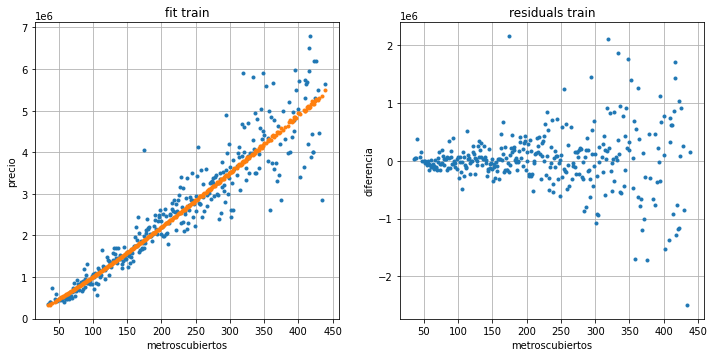

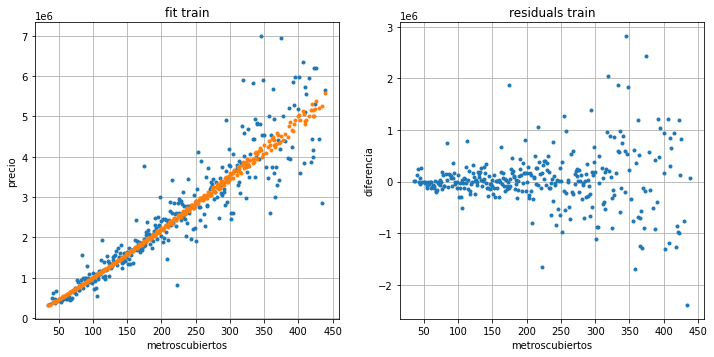

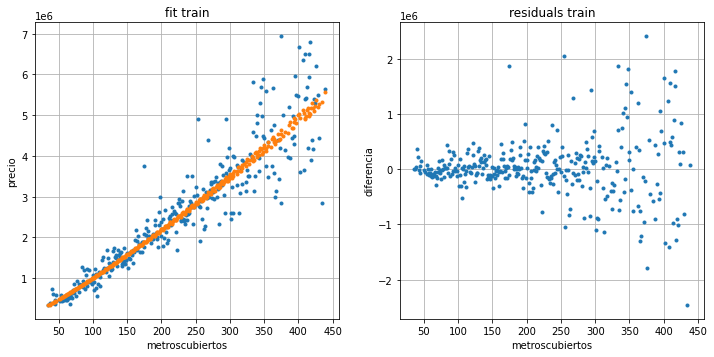

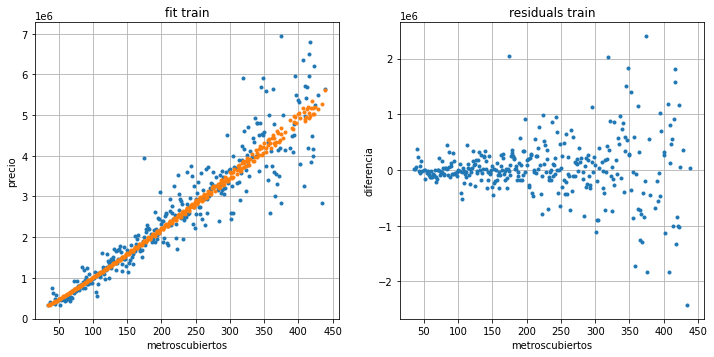

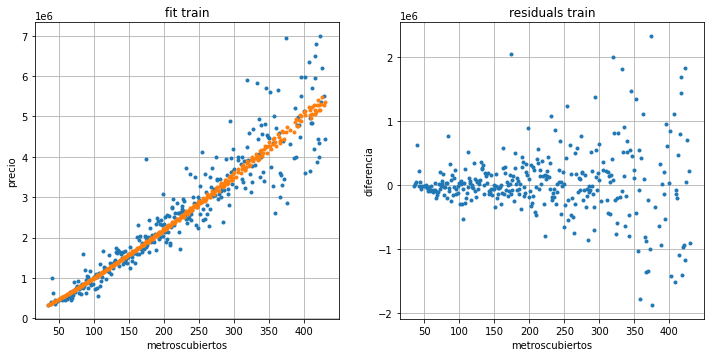

MEAN ERRORS: 0.28280748713112036
VAR ERRORS: 0.00019573271495581813



In [88]:
def evaluate(x):
    ones = np.ones(x.shape)
    return [
        ones,
        np.log(x),
        x * np.sin(x),
        1/np.sqrt(x)
    ]

_, m, v = cross(train_df, test_df, apply_x, apply_y, f, True)

Aunque este nuevo término no introduce una mejora, la viaranza de los errores disminuye muy levemente, por lo que dependiendo del caso de uso puede ser preferible por sobre la que teníamos previamente. Además es necesario tener en cuenta también que sobre el dataset final, el error del modelo 1 fue menor que el del modelo 2.

En resumen, tenemos dos modelos:

##### modelo 1

$$log(y) = \alpha_1 + \alpha_2 * log(x) + \alpha_3 * \phi(x) * sin(\frac{x}{k})$$

MEAN ERRORS: 0.03799249442855789

VAR ERRORS: 9.16278223912125e-05


ERROR: 0.07554453771837644

COEFS: [ 8.65477328e+00  1.12377079e+00 -6.38251168e-05]

##### modelo 2

$$log(y) = \alpha_1 + \alpha_2 * log(x) + \alpha_3 * \phi_1(x) * sin(\frac{x}{k}) + \alpha_4 * x^{-\frac{1}{2}} $$

MEAN ERRORS: 0.0379948737041908

VAR ERRORS: 9.272739712963631e-05


ERROR: 0.07566276143126717

COEFS: [ 7.95118486e+00  1.22351183e+00 -6.38753688e-05  2.36723355e+00]


En este caso, vamos a mirar como estos dos modelos performan al predecir el valor de las casas en Guadalajara.

Text(0.5, 1.0, 'test data (sin agrupar)')

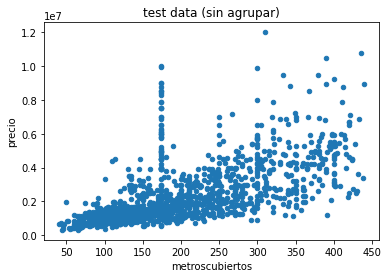

In [89]:
selection_df = df[
    (df['ciudad'] == 'Guadalajara') &
    (df['tipodepropiedad'] == 'Casa')
].dropna()

x = selection_df['metroscubiertos']
y = selection_df['precio']

# graficamos para hacernos una idea de la linealidad entre las dos variables
selection_df.plot.scatter(y='precio', x='metroscubiertos')
plt.title("test data (sin agrupar)")

Error: 0.23210635602572938


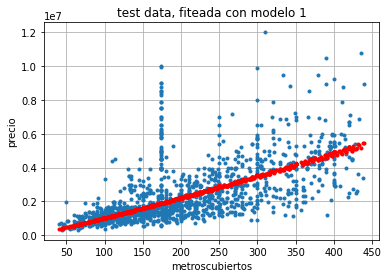

In [90]:
# modelo 1

def evaluate(x):
    ones = np.ones(x.shape)
    return [
        ones,
        np.log(x),
        x * np.sin(x)
    ]

coefs = [8.65477328e+00, 1.12377079e+00, -6.38251168e-05]

y_pred = f(x, coefs)

print(f"Error: {mean_squared_log_error(y, y_pred)}")

plt.plot(x, y, '.')
plt.plot(x, y_pred, '.', color='red')
plt.title("test data, fiteada con modelo 1")
plt.xlabel("metroscubiertos")
plt.ylabel("precio")
plt.grid(True)
plt.show()

Error: 0.232026889590756


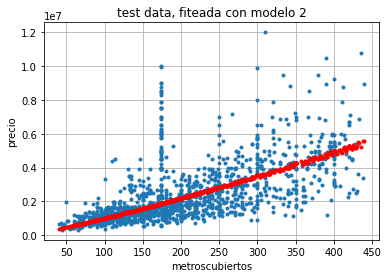

In [91]:
# modelo 2

def evaluate(x):
    ones = np.ones(x.shape)
    return [
        ones,
        np.log(x),
        x * np.sin(x),
        1/np.sqrt(x)
    ]

coefs = [7.95118486e+00, 1.22351183e+00, -6.38753688e-05, 2.36723355e+00]

y_pred = f(x, coefs)

print(f"Error: {mean_squared_log_error(y, y_pred)}")

plt.plot(x, y, '.')
plt.plot(x, y_pred, '.', color='red')
plt.title("test data, fiteada con modelo 2")
plt.xlabel("metroscubiertos")
plt.ylabel("precio")
plt.grid(True)
plt.show()

Aunque a juzgar por los gráficos, aunque son virtualmente iguales, parecen ser consistentes las predicciones respecto a lo que se vió durante el entrenamiento. Tengamos en cuenta las siguientes cosas:

* se entrenó sobre la media de precios con metroscubiertos agrupados
* no son modelos óptimos (se pensaron para mostrar el proceso de selección)
* el modelo 2 tiene un error ligeramente menor sobre el modelo 1